In [1]:
import exmel
import cProfile

In [2]:
def run():
    exmel.align(
        "dataset/不为谁而作的歌/不为谁而作的歌.m.mid",
        "dataset/不为谁而作的歌/不为谁而作的歌.t.mid")

In [3]:
cProfile.run("run()", sort='cumtime')

100%|██████████| 40761/40761 [00:30<00:00, 1350.20it/s]


         79906742 function calls (79722009 primitive calls) in 60.165 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2045    0.119    0.000  143.844    0.070 base_events.py:1962(_run_once)
      7/1    0.000    0.000   61.016   61.016 {built-in method builtins.exec}
     2337    0.133    0.000   56.702    0.024 events.py:87(_run)
34905/179    5.103    0.000   30.518    0.170 alignment.py:115(scan)
    41235   28.108    0.001   28.140    0.001 wisp.py:18(find_last_non_overlapping)
     2045    0.091    0.000   24.678    0.012 selectors.py:310(select)
     2337    0.290    0.000   22.876    0.010 {method 'run' of '_contextvars.Context' objects}
     2045    0.712    0.000   20.977    0.010 selectors.py:304(_select)
     1862    0.014    0.000   16.085    0.009 zmqstream.py:573(_handle_events)
     1835    0.015    0.000   15.979    0.009 ioloop.py:750(_run_callback)
     1857    0.008    0.000   15.842    0.009 zmqstr

Scanning alignments: 100%|██████████| 162/162 [00:05<00:00, 28.87it/s]


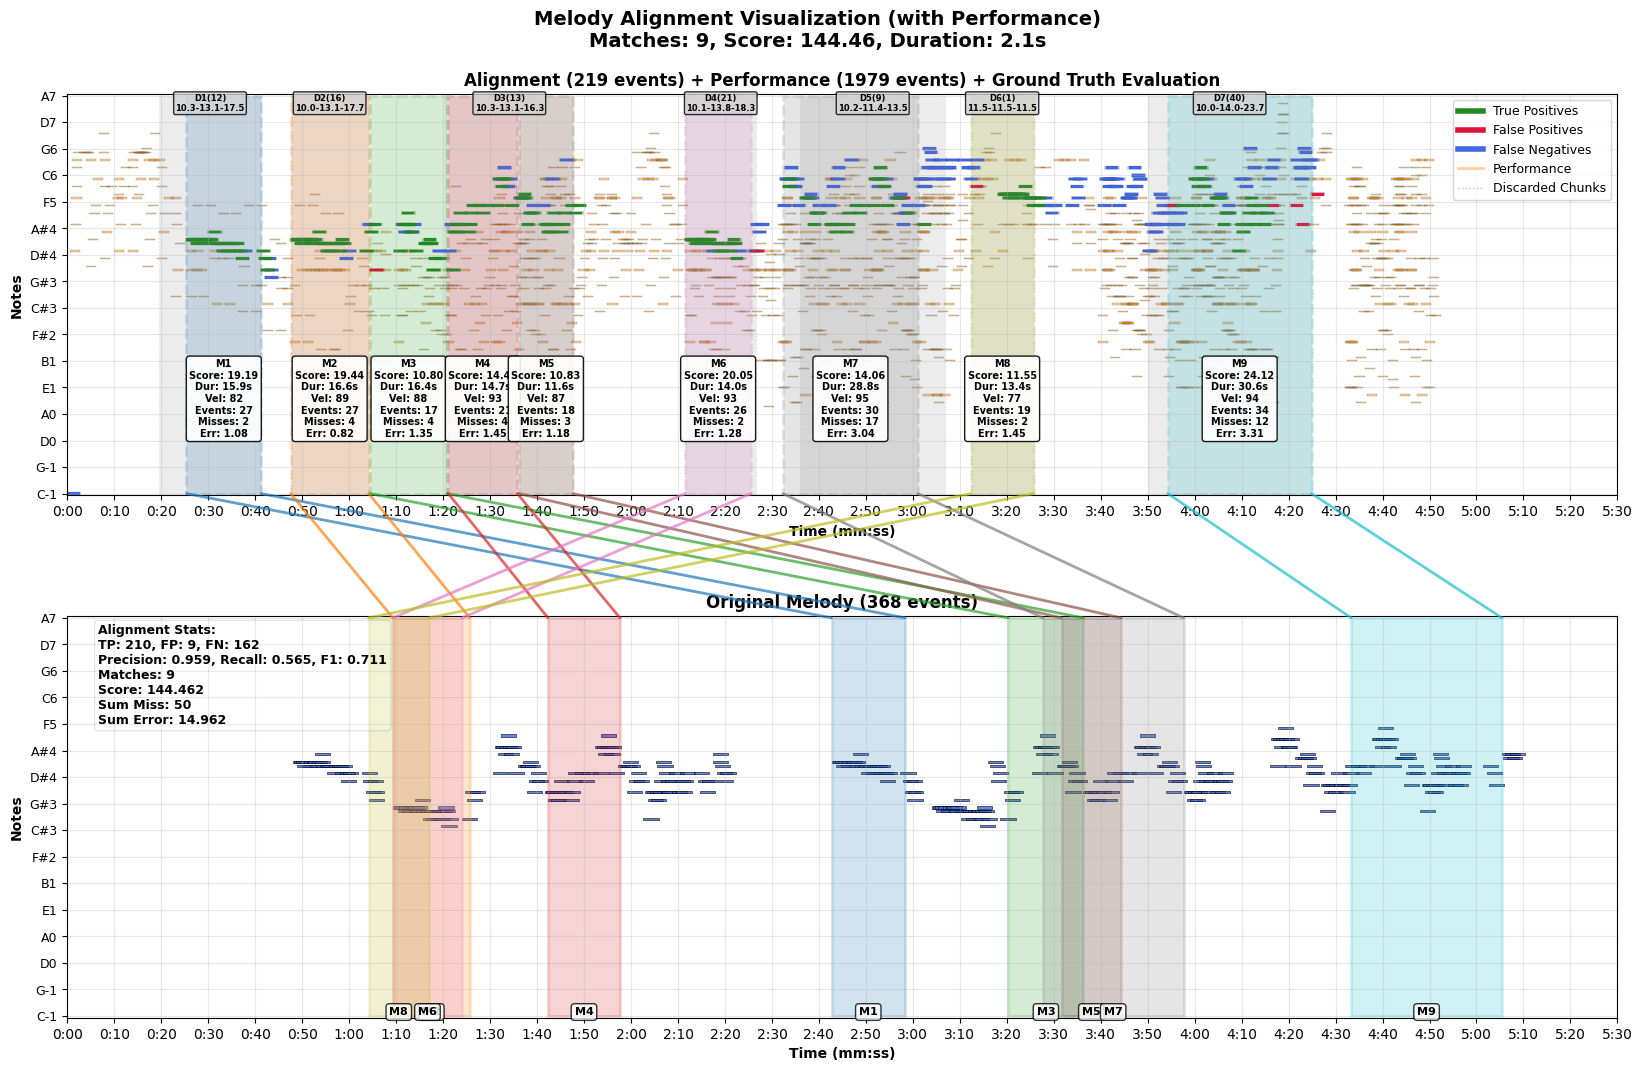

In [ ]:
alignment = exmel.align(
    "dataset/My Heart Will Go On/My Heart Will Go On.m.mid",
    "dataset/My Heart Will Go On/My Heart Will Go On.t.mid")

# exmel.evaluate_melody(
#     exmel.Melody("mid_files/test/piano_melody_test_samples/LFSizzSFXfw/LFSizzSFXfw_rectified.mid", 3),
#     alignment.events,
#     plot=True
# )

exmel.plot_alignment(
    alignment=alignment,
    ref_melody="mid_files/test/melody/176e95cb42b14484472d6a379815744d.est.note",
    performance="mid_files/test/piano_melody_test_samples/LFSizzSFXfw/LFSizzSFXfw_transcription.mid",
    ground_truth=exmel.Melody("mid_files/test/piano_melody_test_samples/LFSizzSFXfw/LFSizzSFXfw_rectified.mid", 3),
)

In [5]:
alignment.discarded_matches

[Match(events=[MidiEvent_(time=25.3464, note='G4', velocity=62), MidiEvent_(time=25.6966, note='G4', velocity=91), MidiEvent_(time=26.0208, note='G4', velocity=89), MidiEvent_(time=26.3255, note='F#4', velocity=86), MidiEvent_(time=26.7057, note='G4', velocity=70), MidiEvent_(time=27.3346, note='F#4', velocity=88), MidiEvent_(time=27.7396, note='G4', velocity=85), MidiEvent_(time=28.4219, note='G4', velocity=70), MidiEvent_(time=28.7409, note='G4', velocity=90), MidiEvent_(time=29.0339, note='F#4', velocity=91), MidiEvent_(time=29.4115, note='G4', velocity=78), MidiEvent_(time=30.0938, note='A4', velocity=77), MidiEvent_(time=31.2331, note='F#4', velocity=80), MidiEvent_(time=31.5456, note='F#4', velocity=89), MidiEvent_(time=32.8867, note='E4', velocity=78), MidiEvent_(time=33.2448, note='F#4', velocity=70), MidiEvent_(time=33.9258, note='F#4', velocity=86), MidiEvent_(time=34.2448, note='F#4', velocity=94), MidiEvent_(time=34.5195, note='E4', velocity=89), MidiEvent_(time=35.5560, no

Scanning alignments: 100%|██████████| 255/255 [00:18<00:00, 13.52it/s]


EvaluationResult(tp=450, fp=15, fn=79, precision=0.967741935483871, recall=0.8506616257088847, f1_score=0.9054325955734406, plot=<Figure size 3000x700 with 1 Axes>)

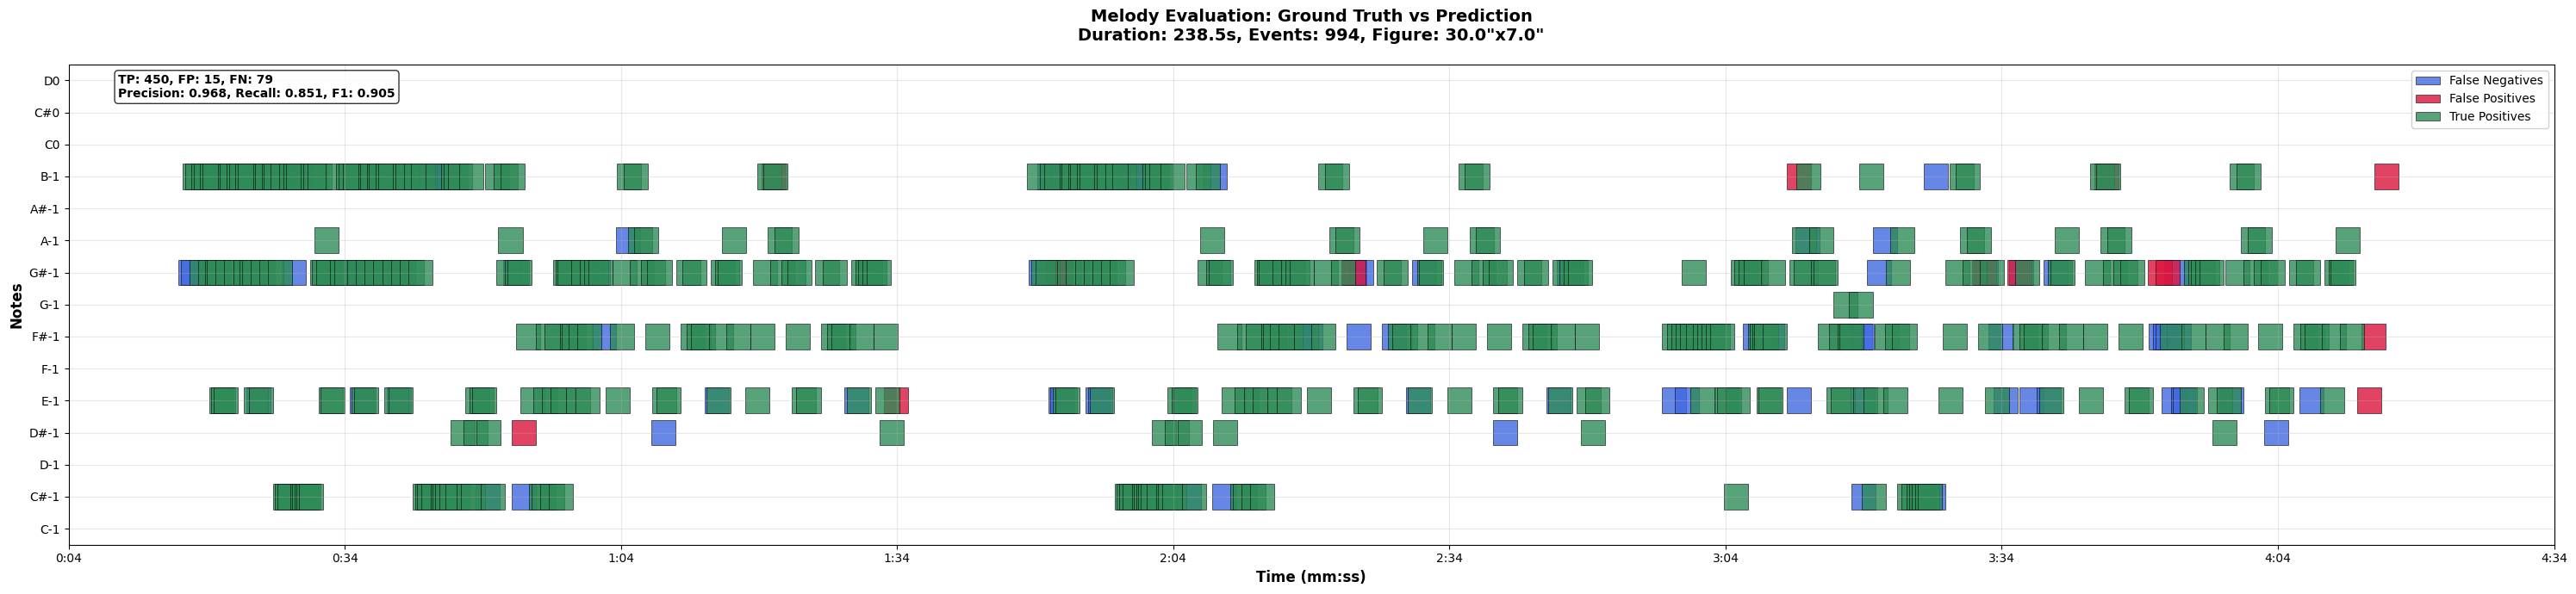

In [5]:
alignment = exmel.align(
    "mid_files/anhao_melody.mid",
    "mid_files/anhao_transcription.mid",
    exmel.duration_adjusted_weighted_sum_velocity)

exmel.evaluate_melody(
    exmel.Melody("mid_files/anhao_rectified.mid", 3),
    alignment.events,
    plot=True
)

Scanning alignments: 100%|██████████| 269/269 [00:29<00:00,  9.13it/s]


EvaluationResult(tp=437, fp=28, fn=92, precision=0.9397849462365592, recall=0.8260869565217391, f1_score=0.8792756539235412, plot=<Figure size 3000x700 with 1 Axes>)

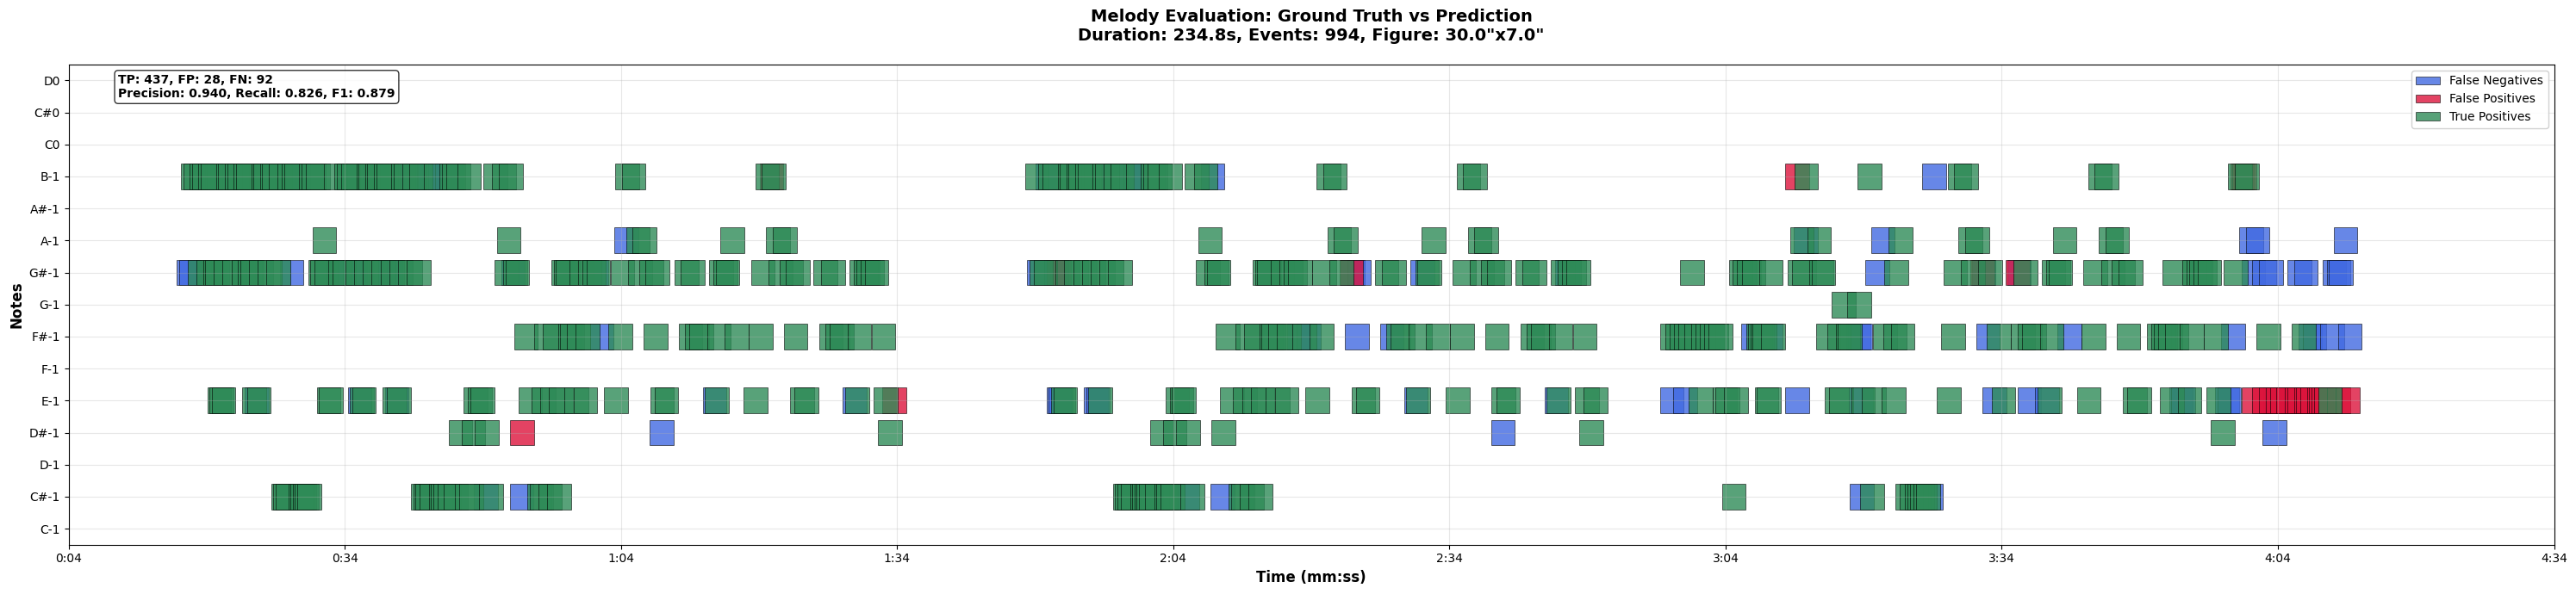

In [6]:
alignment = exmel.align(
    "mid_files/anhao_melody.mid",
    "mid_files/anhao_transcription.mid",
    exmel.duration_adjusted_weighted_sum_velocity,
    split_melody=False)

exmel.evaluate_melody(
    exmel.Melody("mid_files/anhao_rectified.mid", 3),
    alignment.events,
    plot=True
)

Alignment visualization saved to: alignment.png


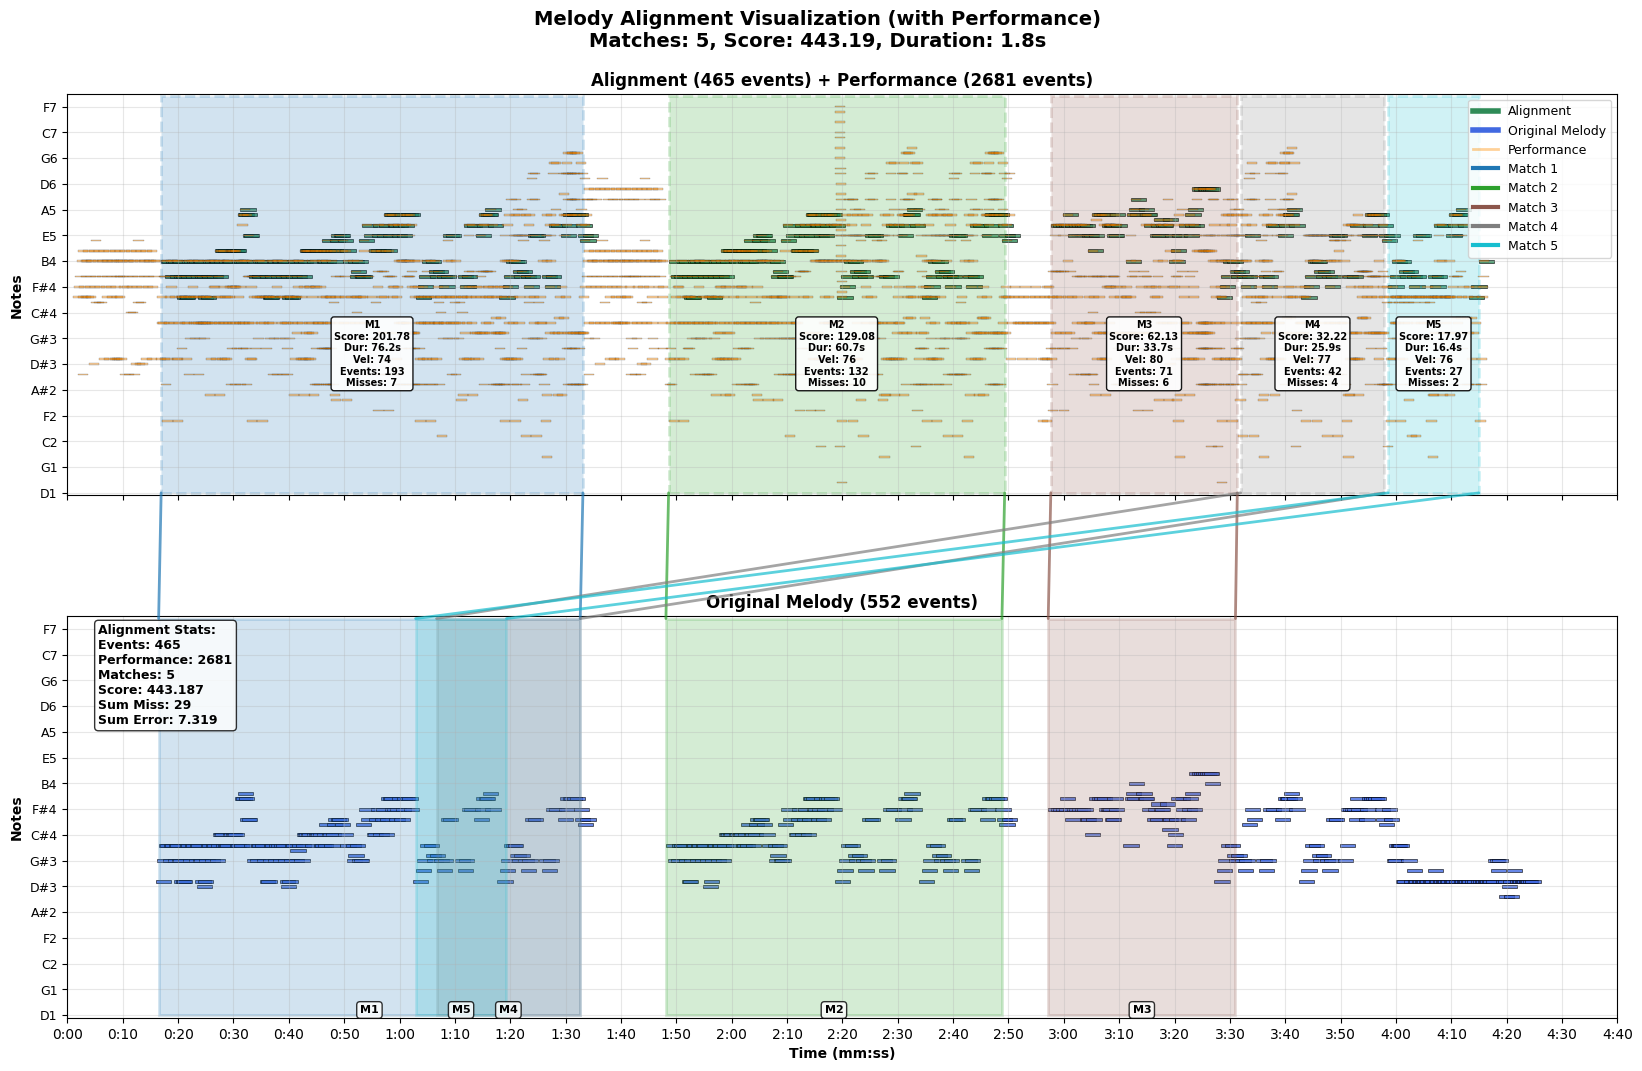

In [4]:
exmel.plot_alignment(
    alignment,
    "mid_files/anhao_melody.mid",
    "mid_files/anhao_transcription.mid",
    save_path="alignment.png")

EvaluationResult(tp=178, fp=3, fn=52, precision=0.9834254143646409, recall=0.7739130434782608, f1_score=0.8661800486618005, plot=<Figure size 2400x700 with 1 Axes>)

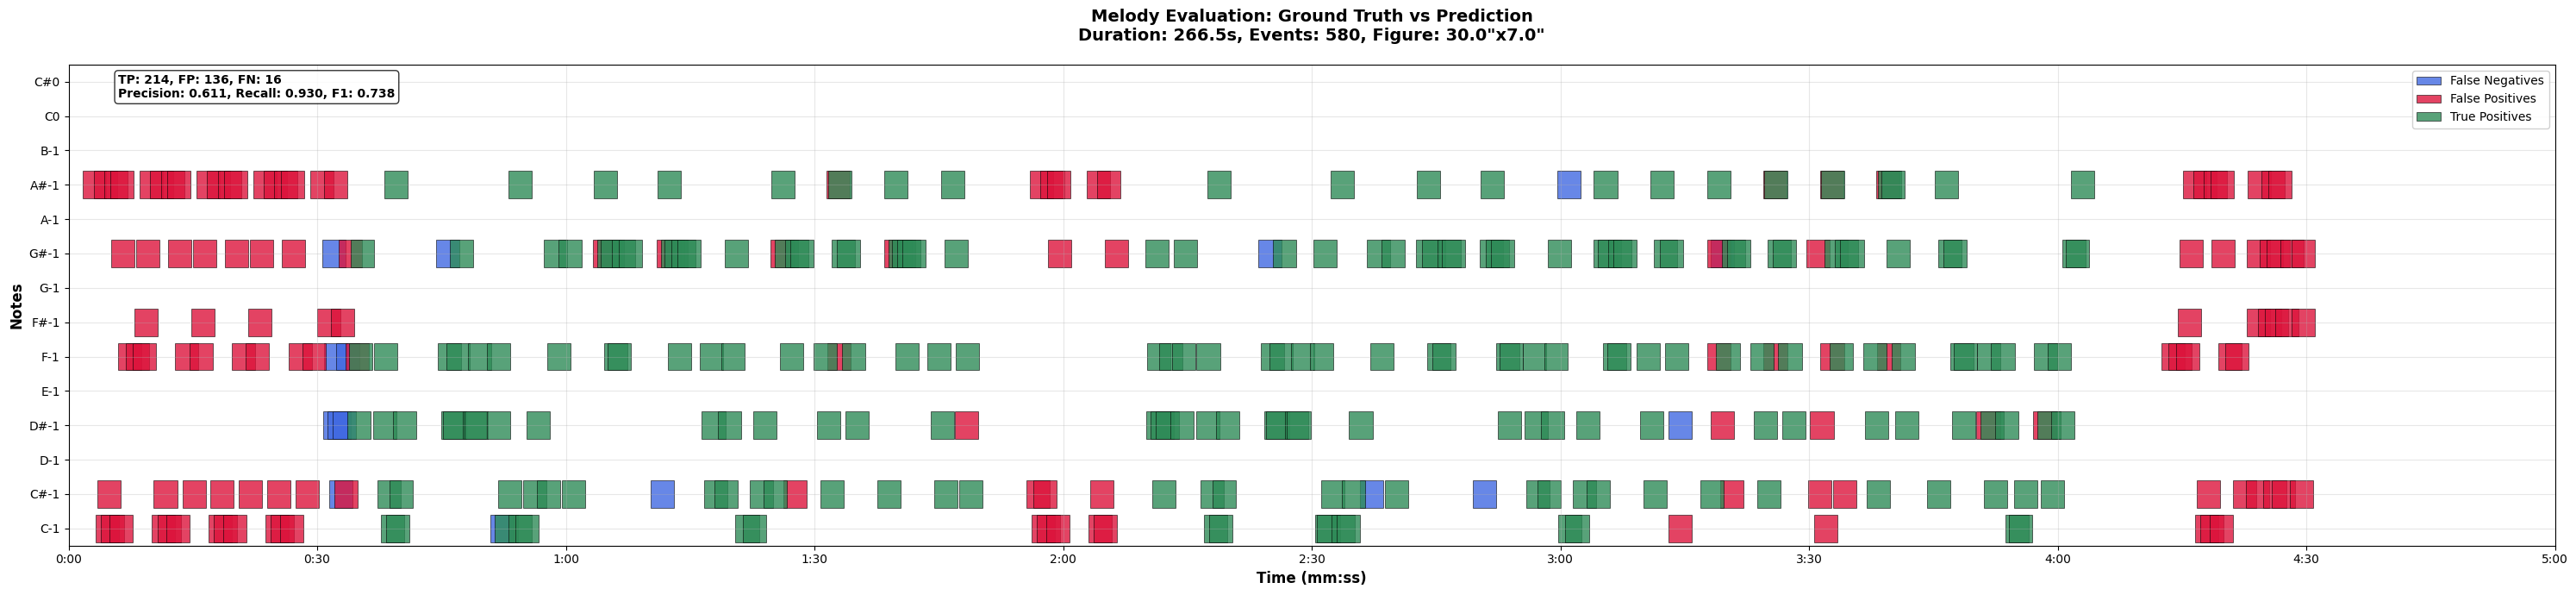

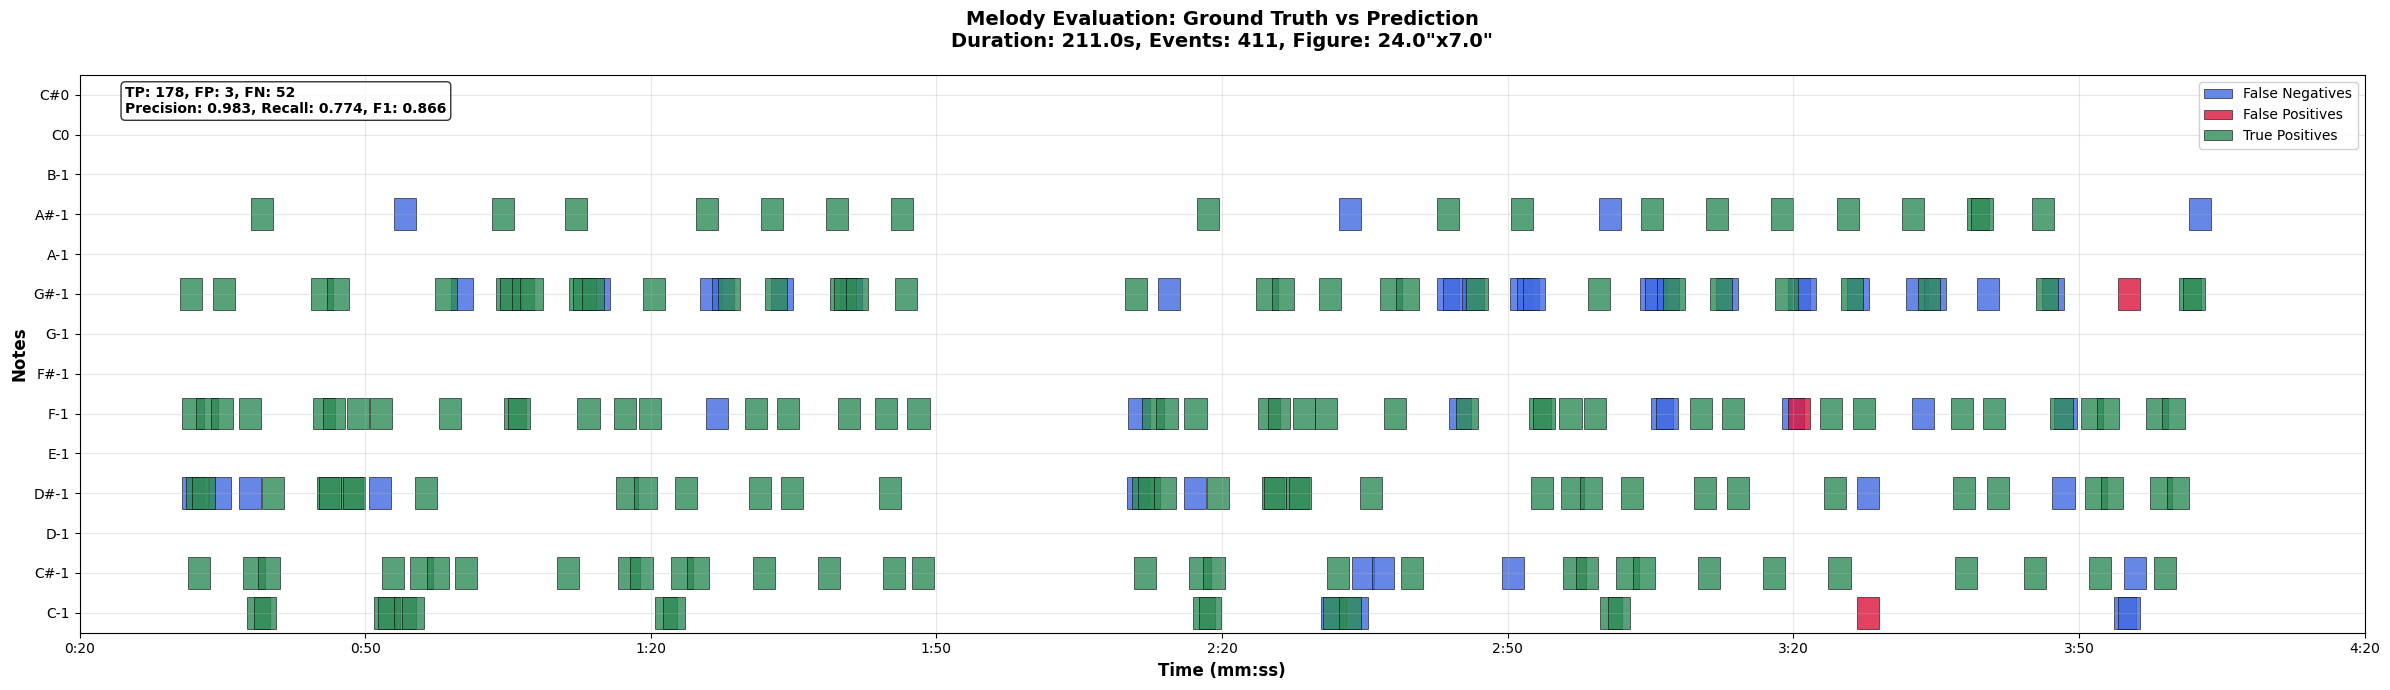

In [8]:
gt = exmel.Melody("mid_files/weiyi_rectified.mid", track_idx=3)
baseline = exmel.Melody("mid_files/weiyi_baseline.mid", track_idx=3)
exmel.evaluate_melody(gt, baseline, plot=True)
exmel.evaluate_melody(gt, alignment.events, plot=True)

# 1

In [12]:
import pretty_midi
import mido
import matplotlib.pyplot as plt

In [13]:
melody = mido.MidiFile("mid_files/anhao_melody.mid")
piano = mido.MidiFile("mid_files/anhao_transcription.mid")

In [14]:
piano

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=61),
    Message('note_on', channel=0, note=64, velocity=71, time=686),
    Message('note_on', channel=0, note=66, velocity=56, time=191),
    Message('note_on', channel=0, note=68, velocity=71, time=181),
    Message('note_on', channel=0, note=71, velocity=72, time=178),
    Message('control_change', channel=0, control=64, value=0, time=145),
    Message('note_on', channel=0, note=68, velocity=0, time=11),
    Message('note_on', channel=0, note=66, velocity=0, time=0),
    Message('note_on', channel=0, note=71, velocity=0, time=2),
    Message('note_on', channel=0, note=64, velocity=0, time=27),
    Message('note_on', channel=0, n

In [15]:
melody

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=52, velocity=77, time=15360),
    Message('note_on', channel=0, note=52, velocity=0, time=230),
    Message('note_on', channel=0, note=56, velocity=77, time=0),
    Message('note_on', channel=0, note=56, velocity=0, time=231),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=230),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=231),
    Message('note_on', channel=0, note=56, velocity=77, time=230),
    Message('note_on', channel=0, note=56, velocity=

In [16]:
pretty_midi.PrettyMIDI("mid_files/anhao_transcription.mid").estimate_tempo()

np.float64(241.46507482037745)

In [17]:
pretty_midi.PrettyMIDI("mid_files/anhao_melody.mid").estimate_tempi()

(array([164.07394489, 170.43437093, 149.51330305, 160.92596288,
        132.36307928, 131.90839695, 169.03888481, 168.2570594 ,
        168.51960211, 157.0766294 , 191.04477612, 169.51147734,
        175.37212449, 190.0990099 , 226.87089716, 201.66301969,
        168.97689769, 179.59910913, 117.31160896, 168.17518248,
        152.58278146, 147.56618275, 168.2570594 , 169.74459725,
        168.33901607, 169.82800983, 157.89473684, 140.1459854 ,
        162.98811545, 137.60152891, 105.61056106, 168.91495601,
        144.63276836, 166.83562636, 171.42857143, 169.16299559,
        168.91495601, 142.83942963, 169.03888481, 146.28571429,
        144.63276836, 142.83942963, 113.16306483, 142.9280397 ,
        171.42857143, 166.71490593, 169.03888481, 144.54203262,
        168.91495601, 166.71490593, 169.16299559, 171.30111524,
        166.71490593, 166.59436009, 168.91495601, 187.62214984,
        191.36212625, 191.57427938, 187.4186551 , 150.        ,
        152.51544572, 155.11669659, 150.

In [18]:
import vis

ModuleNotFoundError: No module named 'vis'

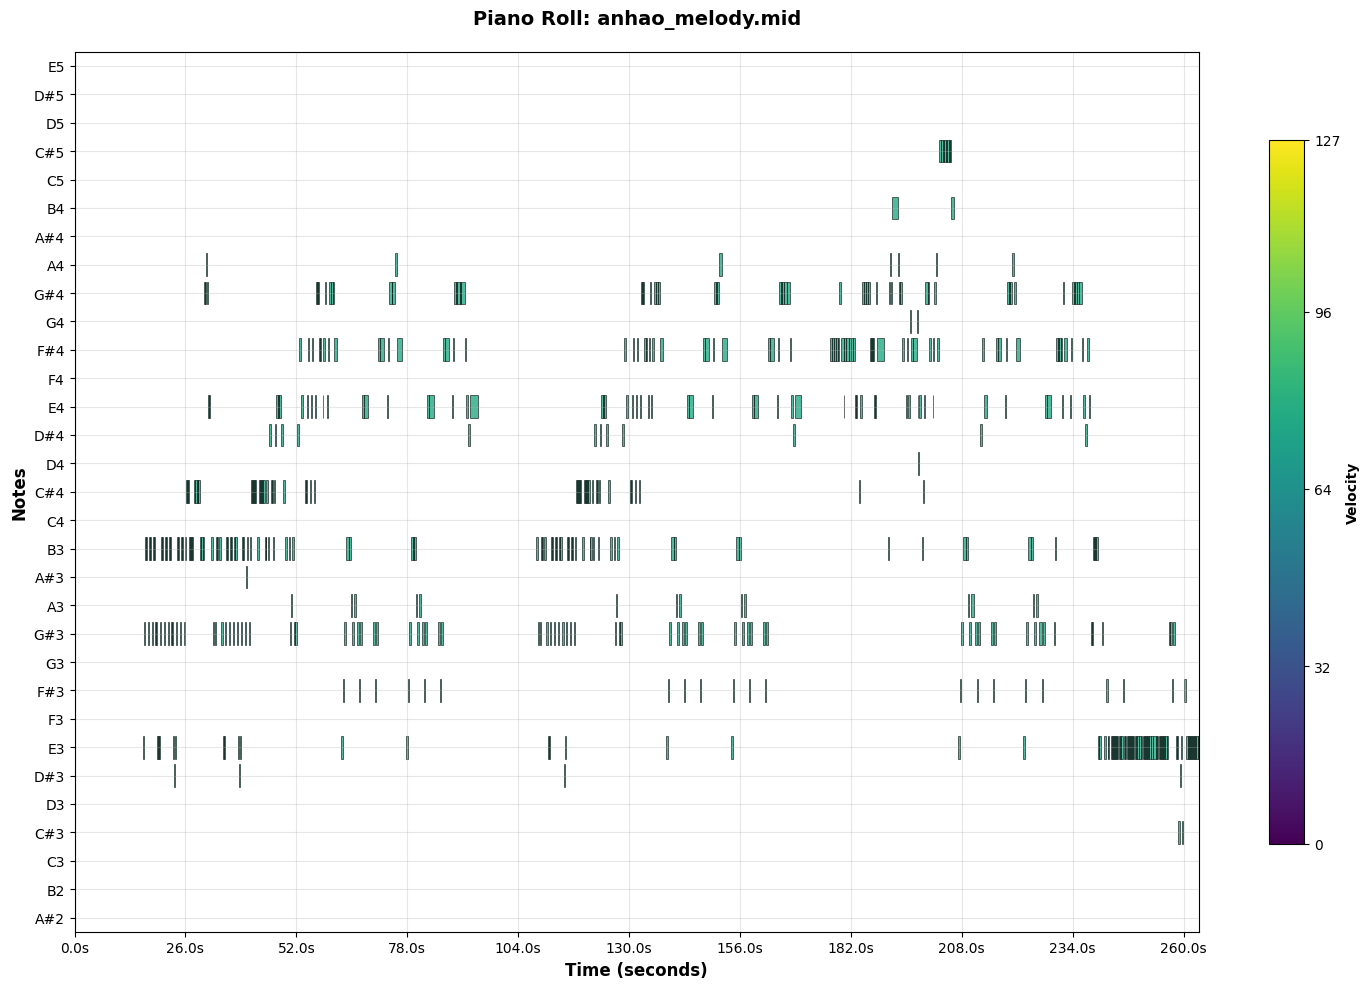

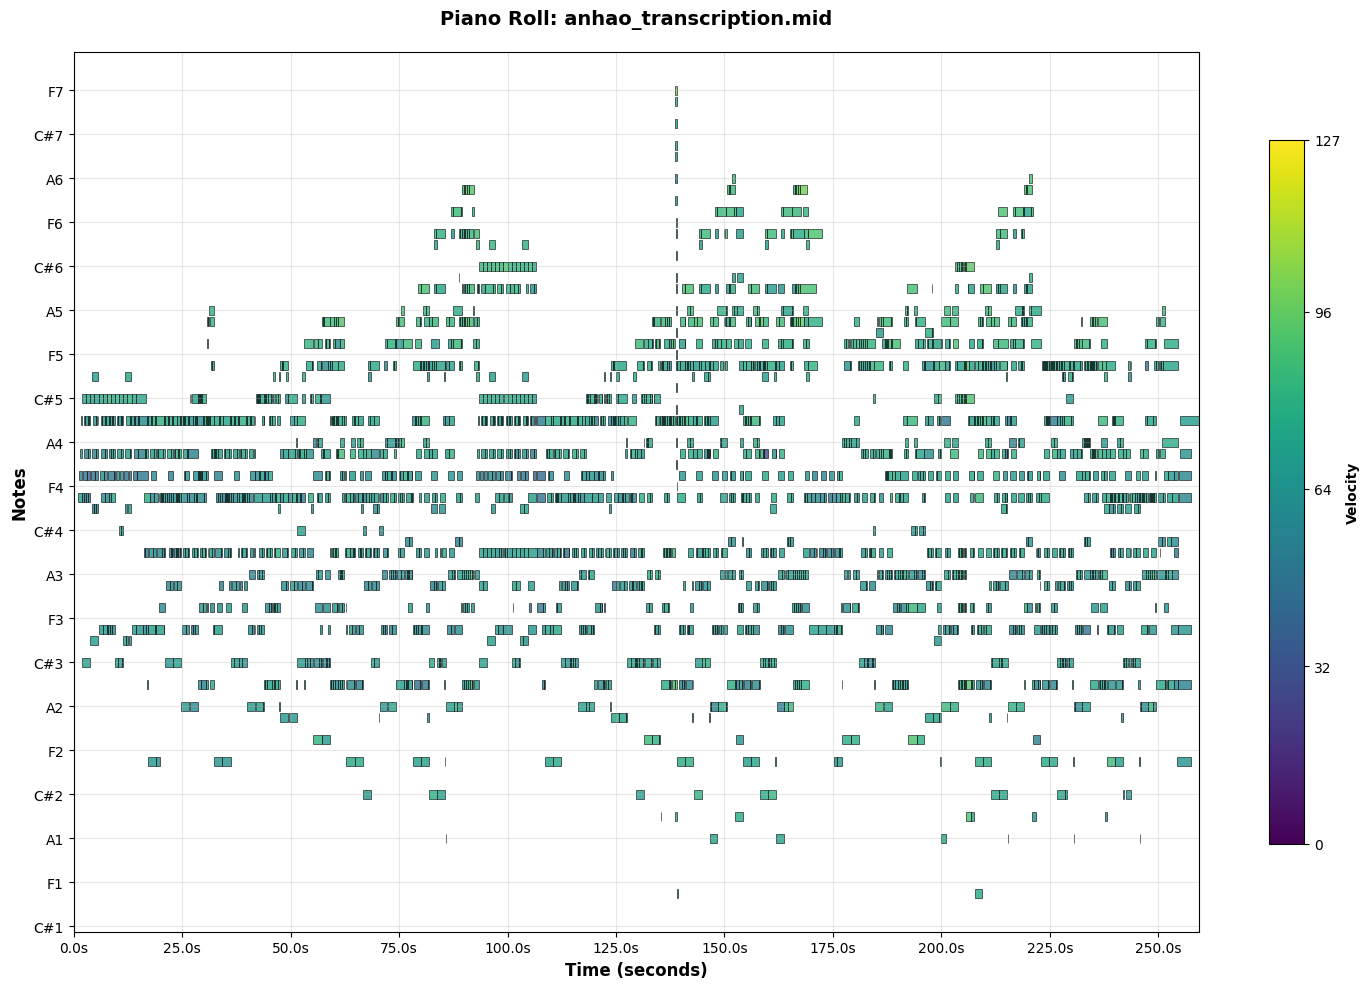

In [ ]:
vis.display_midi_piano_roll("mid_files/anhao_melody.mid")
vis.display_midi_piano_roll("mid_files/anhao_transcription.mid")